In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn import svm
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

In [90]:
train = pd.read_csv(r'C:\Users\saish\Downloads\MessagePolarity_ParticipantsData\MessagePolarity_ParticipantsData\Train.csv')

In [91]:
test = pd.read_csv(r'C:\Users\saish\Downloads\MessagePolarity_ParticipantsData\MessagePolarity_ParticipantsData\Test.csv')

In [92]:
train.shape, test.shape

((947, 54), (527, 53))

In [93]:
train.isnull().sum().sum()

0

In [95]:
from sklearn.utils import resample

df_majority = train[train.IsGoodNews==0]
df_minority = train[train.IsGoodNews==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=579,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
train.IsGoodNews.value_counts()

1    579
0    579
Name: IsGoodNews, dtype: int64

In [96]:
train.head()

,Freq_Of_Word_1,Freq_Of_Word_2,Freq_Of_Word_3,Freq_Of_Word_4,Freq_Of_Word_5,Freq_Of_Word_6,Freq_Of_Word_7,Freq_Of_Word_8,Freq_Of_Word_9,Freq_Of_Word_10,...,Freq_Of_Word_45,Freq_Of_Word_46,Freq_Of_Word_47,Freq_Of_Word_48,Freq_Of_Word_49,Freq_Of_Word_50,TotalEmojiCharacters,LengthOFFirstParagraph,StylizedLetters,IsGoodNews
1,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,3.837751,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.195476,-0.408024,0
2,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.187634,-0.392578,0
4,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,0.930461,-0.028751,-0.113133,-0.128592,0
6,-0.351864,-0.318036,-0.561952,-0.039223,7.477691,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.211160,-0.413640,0
8,-0.351864,-0.318036,0.794968,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.084010,-0.107383,-0.219003,-0.385557,0


In [97]:
train.IsGoodNews.value_counts()

1    579
0    579
Name: IsGoodNews, dtype: int64

In [98]:
train.IsGoodNews.value_counts(normalize=True)

1    0.5
0    0.5
Name: IsGoodNews, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


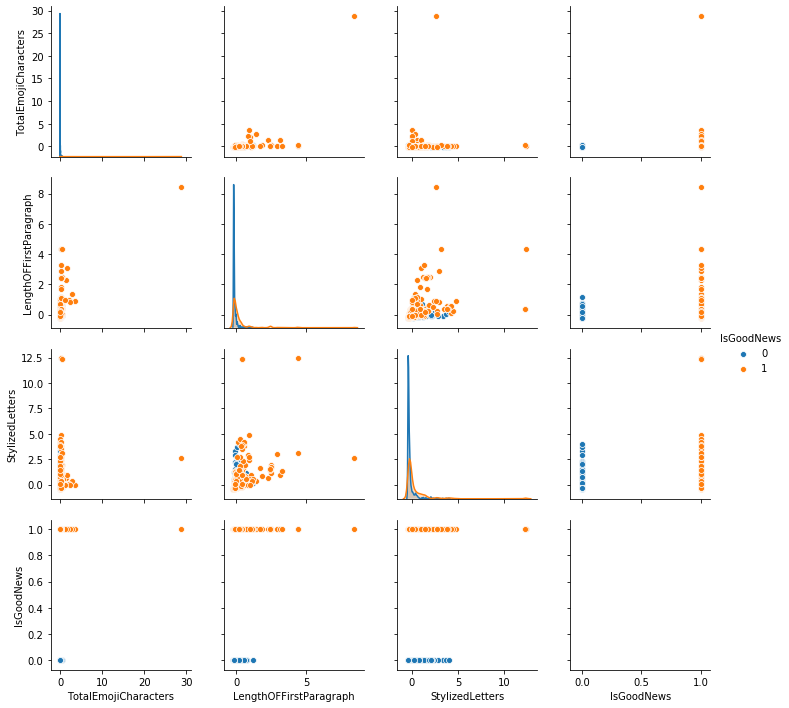

In [46]:
sns.pairplot(data = train[['TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters', 'IsGoodNews']] , hue= 'IsGoodNews')

In [54]:
train[['TotalEmojiCharacters', 'LengthOFFirstParagraph', 'StylizedLetters','IsGoodNews']].corr()

,TotalEmojiCharacters,LengthOFFirstParagraph,StylizedLetters,IsGoodNews
TotalEmojiCharacters,1.000000,0.602551,0.119532,0.090763
LengthOFFirstParagraph,0.602551,1.000000,0.482246,0.301983
StylizedLetters,0.119532,0.482246,1.000000,0.258844
IsGoodNews,0.090763,0.301983,0.258844,1.000000


In [108]:
# train.drop(['StylizedLetters', 'LengthOFFirstParagraph'], axis=1, inplace=True)
X = train.drop('IsGoodNews', axis=1)
y = train.IsGoodNews

In [109]:
cv = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
score_avg = []

for (trainind, testind) in cv.split(X, y):
    m = lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=100,
                       colsample_bytree=0.5,num_leaves=70,min_child_samples=20,lambda_l1=1.6,lambda_l2=4) 
    X_train = X.iloc[trainind]
    y_train = y.iloc[trainind]
    m.fit(X_train,y_train)
    X_test =  X.iloc[testind]
    y_test = y.iloc[testind]
    score_avg.append(f1_score(y_pred=m.predict(X_test),y_true=y_test))
    
print(pd.DataFrame(data=score_avg))


          0
0  0.891892
1  0.875000
2  0.852941
3  0.900000
4  0.911392
5  0.894737
6  0.947368
7  0.947368
8  0.906667
9  0.916667


In [ ]:
print(sum(score_avg)/len(score_avg))

In [7]:
trainData, validData = train_test_split(train,
                                            test_size=0.2,
                                            stratify=train.IsGoodNews)

In [118]:
trainData.shape , validData.shape

((757, 54), (190, 54))

In [120]:
lgbm  = lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=100,
                       colsample_bytree=0.5,num_leaves=70,min_child_samples=20,lambda_l1=1.6,lambda_l2=4)

lgbm.fit(trainData.drop('IsGoodNews', axis=1), trainData.IsGoodNews)

predictions = lgbm.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

0.8789808917197452

In [111]:
cv = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
score_avg = []

for (trainind, testind) in cv.split(X, y):
    m = XGBClassifier()

    X_train = X.iloc[trainind]
#     print(X_train)
    y_train = y.iloc[trainind]
    m.fit(X_train,y_train)
    X_test = X.iloc[testind]
    y_test = y.iloc[testind]
    score_avg.append(f1_score(y_pred=m.predict(X_test),y_true=y_test))
    
print(pd.DataFrame(data=score_avg))

          0
0  0.882353
1  0.918919
2  0.793651
3  0.921053
4  0.909091
5  0.873239
6  0.918919
7  0.960000
8  0.901408
9  0.929577


In [112]:
print(sum(score_avg)/len(score_avg))

0.9008210465447635


## Xgboost tuning

In [142]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(trainData.drop('IsGoodNews', axis=1), trainData.IsGoodNews)
predictions = lgbm.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

0.8789808917197452

In [144]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_metho

In [146]:
gsearch1.best_params_

{'max_depth': 7, 'min_child_weight': 1}

In [147]:
gsearch1.best_score_

0.906597000672523

In [148]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_...ad=4,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
     

In [149]:
gsearch2.best_score_

0.9129059094280769

In [150]:
gsearch2.best_params_

{'gamma': 0.3}

In [151]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.3,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_method=None,
                              

In [152]:
gsearch3.best_score_

0.9151266876689232

In [153]:
gsearch3.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.8}

In [165]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0.3,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, su

In [166]:
gsearch4.best_score_

0.9151266876689232

In [159]:
gsearch4.best_params_

{'reg_alpha': 0}

In [160]:
param_test5 = {
 'n_estimators':[100, 200, 300, 400, 500]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0.3,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, su

In [161]:
gsearch5.best_score_

0.9124143658290848

In [162]:
gsearch5.best_params_

{'n_estimators': 200}

In [169]:
param_test6 = {
 'learning_rate':[0,0.1, 0.001, 0.005, 0.01, 0.05]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0.3,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=7, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, su

In [170]:
gsearch6.best_score_

0.9151266876689232

In [104]:
xgb = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

xgb.fit(train.drop('IsGoodNews', axis=1), train.IsGoodNews)

# predictions = xgb.predict(validData.drop('IsGoodNews', axis=1))
# f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [22]:
confusion_matrix(y_true=validData.IsGoodNews, y_pred=predictions)

array([[112,   4],
       [  7,  67]], dtype=int64)

## Light GBM Tuning

In [180]:
param_test1 ={'num_leaves': [10, 20, 30, 40, 50, 60, 70], 
             'min_child_samples': [10, 20, 30, 40, 50], 
            'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450]}


lgbm= lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=100,
                       colsample_bytree=0.5,num_leaves=70,min_child_samples=20,lambda_l1=1.6,lambda_l2=4) 

gsearch1 = GridSearchCV(estimator=lgbm, param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.5,
                                      importance_type='split', lambda_l1=1.6,
                                      lambda_l2=4, learning_rate=0.1,
                                      max_depth=-1, min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=70, objective=None,
                                      random_state=22...ha=0.0,
                                      reg_lambda=0.0, scale_pos_weight=3,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid=False, n_jobs=4,
          

In [181]:
gsearch1.best_score_

0.9109049278512366

In [182]:
gsearch1.best_params_


{'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 10}

In [11]:
param_test2 = {"learning_rate"    : [ 0.20, 0.25, 0.30, 0.35, 0.40, 0.45 ] ,
 "max_depth"        : [  5, 6, 7,8, 10, 12],
 "min_child_weight" : [ 1, 2, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.05,0.1, 0.2 ],
 "colsample_bytree" : [ 0.3, 0.35,0.4, 0.5 , 0.7, 0.8,0.9 ] }
lgbm= lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=300,
                       colsample_bytree=0.5,num_leaves=10,min_child_samples=30,lambda_l1=1.6,lambda_l2=4) 

gsearch2 = GridSearchCV(estimator=lgbm, param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.5,
                                      importance_type='split', lambda_l1=1.6,
                                      lambda_l2=4, learning_rate=0.1,
                                      max_depth=-1, min_child_samples=30,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=300,
                                      n_jobs=-1, num_leaves=10, objective=None,
                                      random_state=22...
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.35, 0.4, 0.5, 0.7, 0.8,
              

In [12]:
gsearch2.best_score_

0.9126117019463539

In [13]:
gsearch2.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.35,
 'max_depth': 7,
 'min_child_weight': 2}

In [109]:
lgbm= lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.35,n_estimators=300,
    colsample_bytree=0.7,num_leaves=10,min_child_samples=30,lambda_l1=1.6,lambda_l2=4, max_depth=7,min_child_weight= 1, gamma=0.0)

lgbm.fit(train.drop('IsGoodNews', axis=1), train.IsGoodNews)
predictions = lgbm.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

0.979591836734694

In [16]:
confusion_matrix(y_true=validData.IsGoodNews, y_pred=predictions)

array([[109,   7],
       [  3,  71]], dtype=int64)

## Random Forest

In [29]:
RF = RandomForestClassifier(random_state=42)
RF.fit(trainData.drop('IsGoodNews', axis=1), trainData.IsGoodNews)
predictions = RF.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.896551724137931

In [30]:
confusion_matrix(y_true=validData.IsGoodNews, y_pred=predictions)

array([[110,   6],
       [  9,  65]], dtype=int64)

In [31]:
RF.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>

In [32]:
param_test1 = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
RF = RandomForestClassifier(random_state=42)

gsearch1 = GridSearchCV(estimator=RF, param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train.drop('IsGoodNews', axis=1),train.IsGoodNews)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=4,
             param_grid={'bootstrap': [True, Fal

In [33]:
gsearch1.best_score_

0.9092473611533596

In [34]:
gsearch1.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [114]:
RF = RandomForestClassifier(criterion = 'entropy',bootstrap= False, max_depth= 20, max_features= 'auto', min_samples_leaf= 1, min_samples_split = 2,
 n_estimators =1400,random_state=42)

RF.fit(train.drop('IsGoodNews', axis=1), train.IsGoodNews)
predictions = RF.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

0.9793103448275862

In [39]:
confusion_matrix(y_true=validData.IsGoodNews, y_pred=predictions)

array([[111,   5],
       [  8,  66]], dtype=int64)

In [52]:
SVM = svm.SVC(kernel='linear')
SVM.fit(trainData.drop('IsGoodNews', axis=1), trainData.IsGoodNews)
predictions = SVM.predict(validData.drop('IsGoodNews', axis=1))
f1_score(y_true=validData.IsGoodNews, y_pred=predictions)

0.8827586206896552

In [53]:
confusion_matrix(y_true=validData.IsGoodNews, y_pred=predictions)

array([[109,   7],
       [ 10,  64]], dtype=int64)

In [130]:
test.isna().sum().sum()

0

In [122]:
test_pred_lgbm = lgbm.predict(test)
test_pred_xgb = xgb.predict(test)
test_pred_rf = RF.predict(test)

In [123]:
import statistics 

result = []
for a,b,c in zip(test_pred_lgbm,test_pred_xgb,test_pred_rf):
    mylist = [a,b,c]
    final_pred = statistics.mode(mylist)
    result.append(final_pred)

In [124]:
test_pred = pd.DataFrame(result, columns=['IsGoodNews'])

In [125]:
test_pred.IsGoodNews.value_counts()

0    328
1    199
Name: IsGoodNews, dtype: int64

In [126]:
test_pred.to_excel('Sample_Submission.xlsx', index=False)